In [8]:
import numpy as np
from datetime import datetime, timedelta
import os
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
# 读取数据并创建DataFrame
data = pd.read_csv('000001.SZ.csv')
df = pd.DataFrame(data)
        
# 转换日期列为日期时间类型
df['TRADE_DT'] = pd.to_datetime(df['TRADE_DT'], format='%Y%m%d')
        
# 按日期排序
df.sort_values('TRADE_DT', inplace=True)
        
# 初始化变量
peaks = []
valleys = []

# 找到峰值和谷值
for i in range(1, len(df) - 1):
    if df['S_DQ_CLOSE'][i] > df['S_DQ_CLOSE'][i-1] and df['S_DQ_CLOSE'][i] > df['S_DQ_CLOSE'][i+1]:
        peaks.append({'date': df['TRADE_DT'][i], 'price': df['S_DQ_CLOSE'][i]})
    elif df['S_DQ_CLOSE'][i] < df['S_DQ_CLOSE'][i-1] and df['S_DQ_CLOSE'][i] < df['S_DQ_CLOSE'][i+1]:
        valleys.append({'date': df['TRADE_DT'][i], 'price': df['S_DQ_CLOSE'][i]})

# 计算波动周期的时间间隔和涨幅
result_data = []
for i in range(len(valleys) - 1):
    valley_date = valleys[i]['date']
    valley_price = valleys[i]['price']
    next_valley_date = valleys[i+1]['date']
    next_valley_price = valleys[i+1]['price']
            
# 寻找最高点价格
    highest_price = df[(df['TRADE_DT'] > valley_date) & (df['TRADE_DT'] < next_valley_date)]['S_DQ_CLOSE'].max()
            
    price_change = (highest_price - valley_price) / valley_price * 100
    interval = (next_valley_date - valley_date).days

    result_data.append({'波动周期起始日期': valley_date,
                        '波动周期终止日期': next_valley_date,
                        '最低点价格': valley_price,
                        '最高点价格': highest_price,
                        '涨幅': price_change,
                        '时间间隔（天）': interval})
#峰值曲线的谷值，找低点
peaks_valleys = [] 
         
for i in range(2,len(peaks)-1):
    if peaks[i-1]['price'] < peaks[i-2]['price'] and peaks[i]['price'] < peaks[i-1]['price'] and peaks[i]['price'] < peaks[i+1]['price']:
        peaks_valleys.append({'date': peaks[i]['date'], 'price': peaks[i]['price']})
        
low_points = []
for pv in peaks_valleys:
    low_date_front = pv['date']
    low_index = valleys.index(next(v for v in valleys if v['date'] > low_date_front))
    low_price = valleys[low_index]['price']
    low_date = valleys[low_index]['date']
    low_points.append({'low_date': low_date, 'low_price': low_price})
            
#谷值曲线的峰值，找高点
valleys_peaks = [] 
         
for i in range(2,len(valleys)-1):
    if valleys[i-1]['price'] > valleys[i-2]['price'] and valleys[i]['price'] > valleys[i-1]['price'] and valleys[i]['price'] > valleys[i+1]['price']:
        valleys_peaks.append({'date': valleys[i]['date'], 'price': valleys[i]['price']})
        
high_points = []
for vp in valleys_peaks:
    high_date_front = vp['date']
    high_index = peaks.index(next(p for p in peaks if p['date'] > high_date_front))
    high_price = peaks[high_index]['price']
    high_date = peaks[high_index]['date']
    high_points.append({'high_date': high_date, 'high_price': high_price})

In [10]:
high_points_df = pd.DataFrame(high_points)
high_points_df.insert(loc=2, column='state', value=1)
low_points_df = pd.DataFrame(low_points)
low_points_df.insert(loc=2, column='state', value=-1)
high_points_df.columns = ['date', 'price', 'state']
low_points_df.columns = ['date', 'price', 'state']
points_df = pd.concat([high_points_df, low_points_df])
points_df.sort_values(by='date' , inplace=True, ascending=True)
points_df = points_df.reset_index(drop=True)

In [11]:
#提取横盘出现的位置
sideways = []
for i in range(0,len(points_df)-2):
    if points_df['state'][i] == points_df['state'][i+1]:
        sideways.append({'index':i, 'state':points_df['state'][i], 'date':points_df['date'][i], 'price':points_df['price'][i]})
sideways = pd.DataFrame(sideways)

In [12]:
#寻找横盘
sideways_all = []
for i in range(len(sideways)):
    if sideways['state'][i] == 1:
        end_date = df[(df['TRADE_DT'] >= sideways['date'][i]) & (df['S_DQ_PRECLOSE'] > sideways['price'][i])]['TRADE_DT'].min() - timedelta(days=1)
        start_date = sideways['date'][i]
        high_ma_price = df[(df['TRADE_DT'] >= start_date) & (df['TRADE_DT'] <= end_date)]['S_DQ_PRECLOSE'].max()
        low_ma_price = df[(df['TRADE_DT'] >= start_date) & (df['TRADE_DT'] <= end_date)]['S_DQ_PRECLOSE'].min()
        start_date = df[(df['TRADE_DT'] <= sideways['date'][i]) & ((df['S_DQ_PRECLOSE'] > high_ma_price) | (df['S_DQ_PRECLOSE'] < low_ma_price))]['TRADE_DT'].max() + timedelta(days=1)
        interval = (end_date - start_date).days
        sideways_all.append({'start_date':start_date, 'end_date':end_date, 'interval':interval, 'state':sideways['state'][i]})
    else:
        end_date = df[(df['TRADE_DT'] >= sideways['date'][i]) & (df['S_DQ_PRECLOSE'] < sideways['price'][i])]['TRADE_DT'].min() - timedelta(days=1)
        start_date = sideways['date'][i]
        high_ma_price = df[(df['TRADE_DT'] >= start_date) & (df['TRADE_DT'] <= end_date)]['S_DQ_PRECLOSE'].max()
        low_ma_price = df[(df['TRADE_DT'] >= start_date) & (df['TRADE_DT'] <= end_date)]['S_DQ_PRECLOSE'].min()
        start_date = df[(df['TRADE_DT'] <= sideways['date'][i]) & ((df['S_DQ_PRECLOSE'] > high_ma_price) | (df['S_DQ_PRECLOSE'] < low_ma_price))]['TRADE_DT'].max() + timedelta(days=1)
        interval = (end_date - start_date).days
        sideways_all.append({'start_date':start_date, 'end_date':end_date, 'interval':interval, 'state':sideways['state'][i]})

In [19]:
sideways_all

,start_date,end_date,interval,state
0,2000-03-03,2000-03-07,4.0,1
1,2000-05-23,2000-06-08,16.0,1
2,2000-07-07,2000-09-04,59.0,-1
3,2000-07-29,2007-01-29,2375.0,1
4,2000-12-13,2000-12-21,8.0,-1
...,...,...,...,...
108,2021-07-28,2021-08-05,8.0,-1
109,2021-12-02,2021-12-14,12.0,-1
110,2022-06-15,2022-07-13,28.0,-1
111,2022-11-30,2023-01-03,34.0,1


D:\Program\anaconda3\lib\site-packages\matplotlib\patches.py:1111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


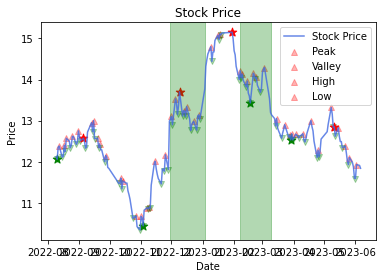

In [23]:
# 获取最后100天的数据
last_hundred_days_df = df.tail(200)
# 绘制折线图
plt.plot(last_hundred_days_df['TRADE_DT'], last_hundred_days_df['S_DQ_CLOSE'], color='royalblue',alpha=0.8)
# 将last_hundred_days_df['TRADE_DT']转换为与peaks中日期格式相同的字符串格式
last_hundred_days_dates = last_hundred_days_df['TRADE_DT'].dt.strftime('%Y-%m-%d')
# 提取最后100天内的峰值和谷值
last_hundred_days_peaks = [peak for peak in peaks if peak['date'].strftime('%Y-%m-%d') in last_hundred_days_dates.values]
last_hundred_days_valleys = [valley for valley in valleys if valley['date'].strftime('%Y-%m-%d') in last_hundred_days_dates.values]
        
# 提取最后100天内的高点和低点
last_hundred_days_high = [high_point for high_point in high_points if high_point['high_date'].strftime('%Y-%m-%d') in last_hundred_days_dates.values]
last_hundred_days_low = [low_point for low_point in low_points if low_point['low_date'].strftime('%Y-%m-%d') in last_hundred_days_dates.values]


# 标记峰值和谷值
for peak in last_hundred_days_peaks:
    plt.scatter(peak['date'], peak['price'], color='red', marker='^', label='Peak',alpha=0.3)
for valley in last_hundred_days_valleys:
    plt.scatter(valley['date'], valley['price'], color='green', marker='v', label='Valley',alpha=0.3)
            
# 标记高点和低点
for high_point in last_hundred_days_high:
    plt.scatter(high_point['high_date'], high_point['high_price'], color='red', marker='*', label='high',s=80)
for low_point in last_hundred_days_low:
    plt.scatter(low_point['low_date'], low_point['low_price'], color='green', marker='*', label='Valley',s=80)

# 设置图形标题和标签
plt.title('Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(labels=['Stock Price', 'Peak', 'Valley','High',"Low"])

#标出横盘位置
plt.axvspan(sideways_all.tail(1)['start_date'], sideways_all.tail(1)['end_date'], alpha=0.3, color='green')
plt.axvspan(sideways_all['start_date'][111], sideways_all['end_date'][111], alpha=0.3, color='green')

#显示图形
plt.show()

In [22]:
plt.figure(figsize=(24,16))

<Figure size 1728x1152 with 0 Axes>

<Figure size 1728x1152 with 0 Axes>